# Tutorial 3: Clustering

**Autores:** Hernán Sarmiento, Andrés Abeliuk, Cinthia Sánchez, Jorge Ortiz

**Fecha:** Octubre 2022

**Objetivo:** El objetivo de este tutorial es relacionarse con `scikit-learn`, `numpy` y `scipy` para entrenar nuestros modelos de clustering, junto con `matplotlib` para hacer visualizaciones de estos.

**Nombre:** AGREGUE SU NOMBRE COMPLETO

# Clustering

La técnica de clustering permite agrupar observaciones o datos que son similares entre sí. 
En este tutorial presentaremos 3 métodos de clustering para particionar datos: 

1.   K-means, 
2.   Clustering jerárquico aglomerativo, y 
3.   DBScan (basado en densidad).


Veremos cómo emplear cada uno de ellos, algunas formas de graficar los datos, y de validar nuestros clusters.

## K-Means

K-means es un método simple para particionar datos en distintos clusters, que intenta minimizar la distancia de cada punto de un cluster a su centroide. 

Para este ejemplo, crearemos datos de evaluaciones de películas. Cada observación corresponde a los ratings que un usuario dio a ciertas películas, por lo que cada atributo es el rating de una película en particular:

In [1]:
import pandas as pd

ratings = [['john', 5, 5, 2, 1], 
           ['mary', 4, 5, 3, 2],
           ['bob', 4, 4, 4, 3],
           ['lisa', 2, 2, 4, 5],
           ['lee', 1, 2, 3, 4],
           ['harry', 2, 1, 5, 5]]

titles = ['user', 'Jaws', 'Star Wars', 'Exorcist', 'Omen']
movies = pd.DataFrame(ratings, columns=titles)
movies

,user,Jaws,Star Wars,Exorcist,Omen
0,john,5,5,2,1
1,mary,4,5,3,2
2,bob,4,4,4,3
3,lisa,2,2,4,5
4,lee,1,2,3,4
5,harry,2,1,5,5


Nuestro objetivo es identificar grupos de usuarios con preferencias cinematográficas similares.

**¿Cómo visualizamos nuestros datos?**

---

Si tuvieramos 2 dimensiones podríamos graficarlos directamente. En este caso, tenemos que reducir la dimensionalidad, para lo cual se pueden usar métodos como PCA y T-SNE. Ambos métodos estan también implementados en `scikit-learn`. Usaremos PCA y graficaremos esta proyección de alta dimensionalidad a baja dimensionalidad.

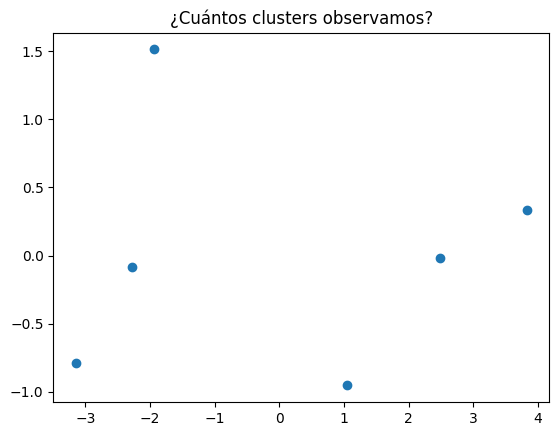

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Elimimnamos la columna user, ya que es sólo un identificador
rates = movies.drop(columns=['user'])

pca = PCA(n_components=2).fit(rates)
rates_pca = pca.transform(rates) 

plt.scatter(rates_pca[:, 0], rates_pca[:, 1])
plt.title("¿Cuántos clusters observamos?")
plt.show()

Ejecutamos k-means y le indicamos que queremos que divida los datos en 2 clusters:

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=20, max_iter=50, random_state=1)
kmeans.fit(rates) #`fit_predict` entrena el modelo y devuelve las predicciones

KMeans(max_iter=50, n_clusters=2, n_init=20, random_state=1)

Lo que estamos haciendo es crear un objeto KMeans, que está configurado para asignar 2 clusters. 

- Usamos `random_state` para tener resultados replicables
- Ejecutamos el método `n_init` veces, donde cada vez se generan centroides que parten aleatoriamente (se queda con el resultado con menor error). 
- `max_iter` indica el número máximo de iteraciones que hará el modelo en caso de no converger antes.

Con el objeto kmeans entrenado podemos preguntar por algunos de los resultados. 

* `cluster_centers_`: centroides finales del modelo.
* `labels_`: asignaciones de cada ejemplo (y_pred).
* `inertia_`: error de los clusters.
* `n_iter_`: iteraciones para encontrar este resultado.


Finalmente le pedimos que nos de las predicciones o clusters asignados a cada instancia.


In [4]:
y_pred = kmeans.labels_ #kmeans.predict(rates)
y_pred

array([1, 1, 1, 0, 0, 0])

**¿Cuántos datos quedaron en cada cluster?**

No hay nada automático para obtener ese resultado, pero podemos usar `numpy` para contar los clusters.

In [5]:
import numpy as np

counts = np.bincount(y_pred)
print(counts)

[3 3]


In [6]:
# Número de iteraciones:
kmeans.n_iter_

3

In [7]:
# centroides resultantes del clustering
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=rates.columns)

,Jaws,Star Wars,Exorcist,Omen
0,1.666667,1.666667,4.0,4.666667
1,4.333333,4.666667,3.0,2.000000


In [8]:
# inertia o error 
kmeans.inertia_

9.333333333333334

In [9]:
#inertia con datos estandarizados
Z = (rates - rates.mean()) / rates.std()
kmeans = KMeans(n_clusters=2, max_iter=50, random_state=1)
kmeans.fit(Z)

kmeans.inertia_, kmeans.labels_

(5.641357394166382, array([1, 1, 1, 0, 0, 0]))

Por otro lado, las asignaciones por cluster se pueden incorporar a una nueva columna en el dataset (representando el *cluster*). **Sin embargo, hay que tener cuidado al agregar esta columna al dataframe original, pues (erróneamente) podrían usarla a futuro en las variables para estimar otro modelo de clustering.**

In [10]:
movies['Cluster_ID'] = y_pred
movies

,user,Jaws,Star Wars,Exorcist,Omen,Cluster_ID
0,john,5,5,2,1,1
1,mary,4,5,3,2,1
2,bob,4,4,4,3,1
3,lisa,2,2,4,5,0
4,lee,1,2,3,4,0
5,harry,2,1,5,5,0


Ahora que tenemos un clustering, podríamos usarlo con datos nuevos, es decir, le podríamos pasar nuevas evaluaciones de películas y el clustering nos diría a cuál cluster corresponden, similar a la clasificación:

In [11]:
import numpy as np

testData = np.array([[4, 5, 1, 2],
                     [3, 2, 4, 4],
                     [2, 3, 4, 1],
                     [3, 2, 3, 3],
                     [5, 4, 1, 4]])

testData = pd.DataFrame(testData, columns=['Jaws', 'Star Wars', 'Exorcist', 'Omen'])

labels = kmeans.predict(testData)
labels

array([1, 0, 1, 1, 1])

In [12]:
newusers = testData.copy()
newusers.insert(loc=0, column='user', value=['paul', 'kim', 'liz', 'tom', 'bill'])
newusers['Cluster ID'] = labels

newusers

,user,Jaws,Star Wars,Exorcist,Omen,Cluster ID
0,paul,4,5,1,2,1
1,kim,3,2,4,4,0
2,liz,2,3,4,1,1
3,tom,3,2,3,3,1
4,bill,5,4,1,4,1


**¿Cómo visualizamos los clusters?**

---

Para ver los resultados del clustering de forma visual, podemos graficarlos y luego pintarlos de colores distintos dependiendo de a qué cluster corresponde cada punto.
En el siguiente código lo que hacemos es graficar los puntos con el argumento `c`, que nos permite indicar de qué color pintar cada punto. Como tenemos el atributo `labels_`, que corresponde al label o asignación para cada uno de los puntos, mediante esta podemos decirle a `matplotlib` que pinte cada punto con el color del cluster que se le fue asignado.

In [13]:
data2 = pd.concat([rates, testData], ignore_index=True)
kmeans = KMeans(n_clusters=2, max_iter=50, random_state=1)
kmeans.fit(data2)

KMeans(max_iter=50, n_clusters=2, random_state=1)

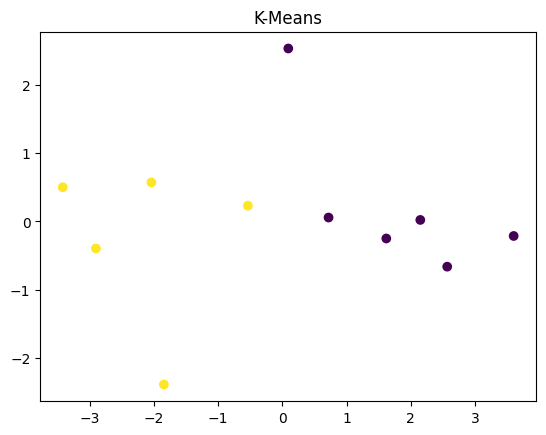

In [14]:
pca = PCA(n_components=2).fit(data2)
data2_pca = pca.transform(data2) 

plt.scatter(data2_pca[:, 0], data2_pca[:, 1], c=kmeans.labels_)
plt.title("K-Means")
plt.show()

**¿Podría haber más de dos clusters?**

---

Usemos el método del codo para determinar si dos clusters fue una decisión acertada.

Una forma de estimar el número de clusters es mediante la suma de la diferencia al cuadrado entre los puntos de cada cluster (SSE). En `scikit-learn` este dato se llama `inertia_`. Una tecnica para encontrar un número razonable de clusters a usar es el **método del codo**, donde calculamos el SSE para varios números de clusters y graficamos como varía el SSE, eligiendo el "mejor". Este concepto de "mejor" no es claro, pero la idea es elegir el último cluster antes de encontrarnos con el punto de _diminishing returns_, que sería cuando aumentar a más clusters nos da una mejora muy pequeña respecto a la que estamos considerando actualmente.

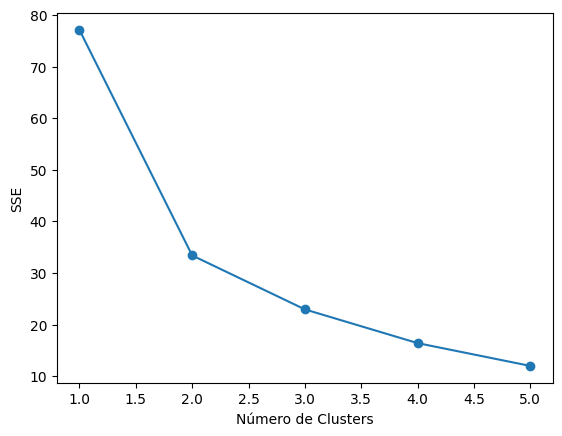

In [15]:
SSE = []
numClusters = list(range(1, 6))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(data2)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

Observamos que el "codo" se encuentra claramente marcado en dos clusters.

## Clustering Jerárquico Aglomerativo (Hierarchical clustering)

En este método lo que hacemos es partir con que cada dato es un cluster independiente de los demás, y luego, mediante una matriz de distancias vamos uniendo datos, creando anidaciones de clusters. Continuamos hasta que quede solo 1 cluster muy grande (o k clusters).

Generalmente estos métodos se grafican como un dendrograma, y usan la distancia euclidiana para calcular las matrices de distancias. Se pueden usar otras métricas de distancia/similitud.

Vamos a presentar 4 criterios para ir uniendo los clusters. Estos corresponden a `complete`, `average`, `single` y `ward`. Aquí una descripción rápida de los criterios:
* `complete`: considera la distancia máxima entre 2 clusters
* `average`: considera la distancia promedio entre 2 clusters
* `single`: considera la distancia mínima entre 2 clusters
* `ward`: minimiza la varianza entre los 2 clusters



Aplicaremos clustering jerárquico aglomerativo al conjunto de datos de animales vertebrados. Cada vertebrado se clasifica en una de las 5 categorías: *mamíferos, reptiles, aves, peces y anfibios*, basándose en un conjunto de atributos explicativos (variables predictoras). Salvo la variable "Name", el resto de los atributos se han convertido en una representación binaria (one hot encoding). 

In [16]:
data = pd.read_csv('http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial8/vertebrate.csv')
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


Para trabajar con clustering jerárquico podemos usar `scikit-learn` o `scipy`. `scikit-learn` no tiene una forma directa de graficar los dendrogramas, pero `scipy` sí.

En `scipy` existe todo un módulo dedicado a clustering jerárquico [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html). En particular aquí usaremos `linkage` para generar las uniones de cada dato y cluster, y `dendrogram` para graficar el árbol.

En `scikit-learn` tenemos [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) para computar los clusters y asignar los labels a cada dato.

Vamos a visualizar los dendogramas de distintos "linkages" o criterios para clustering jerárquicos.

Acá la variable `Z` se llama el "linkage", que es la matriz de similitud con la información de los clusters que encontró el algoritmo.

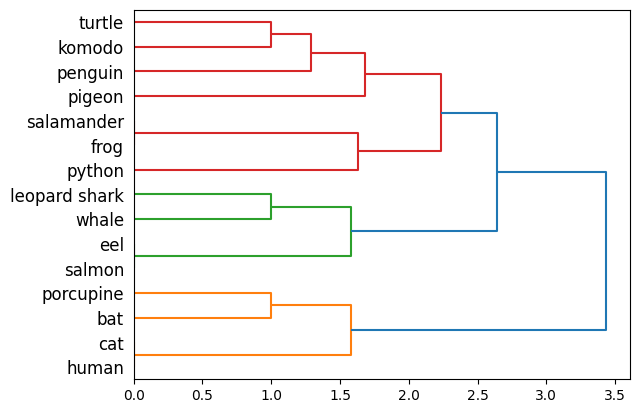

In [17]:
# revisar funciones de distancia/similitud:
# euclidiana, manhattan o cityblock, correlacion, coseno

from scipy.cluster.hierarchy import dendrogram, linkage

names = data['Name']
Y = data['Class']
X = data.drop(['Name','Class'], axis=1)

Z = linkage(X, 'ward', metric='euclidean')
dn = dendrogram(Z, labels=names.tolist(), orientation='right')

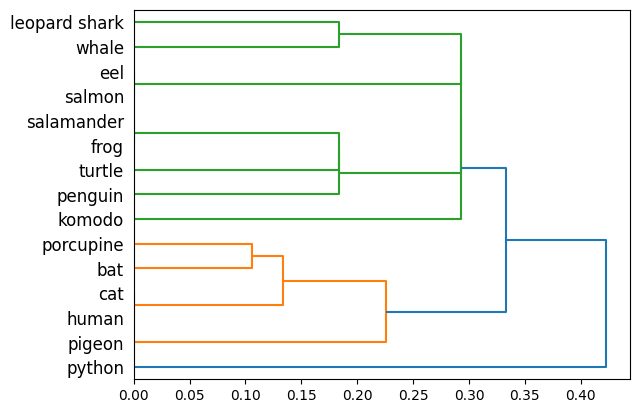

In [18]:
Z = linkage(X, method='single', metric='cosine') # min
dn = dendrogram(Z, labels=names.tolist(), orientation='right')

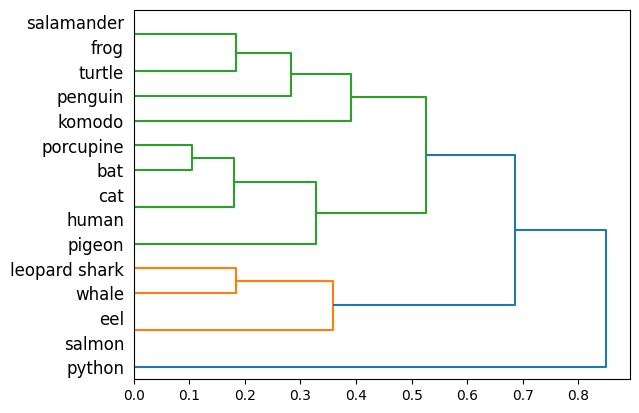

In [19]:
Z = linkage(X, 'average', metric='cosine')
dn = dendrogram(Z, labels=names.tolist(), orientation='right')

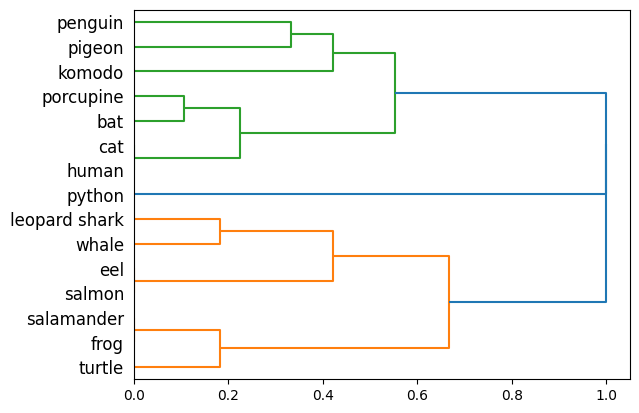

In [20]:
Z = linkage(X, method='complete', metric='cosine') # max
dn = dendrogram(Z, labels=names.tolist(),orientation='right')

Viendo los arboles nos damos cuenta que las divisiones son distintas entre cada método, pero visualmente podemos llegar considerar que 3 clusters es un número razonable.

Visualmente podemos cortar el arbol en distintos puntos para ver cómo se distribuyen los datos en las ramas. Luego manualente decidir viendo el dendrograma cuál sería una buena distancia para cortar el árbol.

Por ejemplo, en el caso de `complete`, 0.5 parece ser un buen número para cortar.

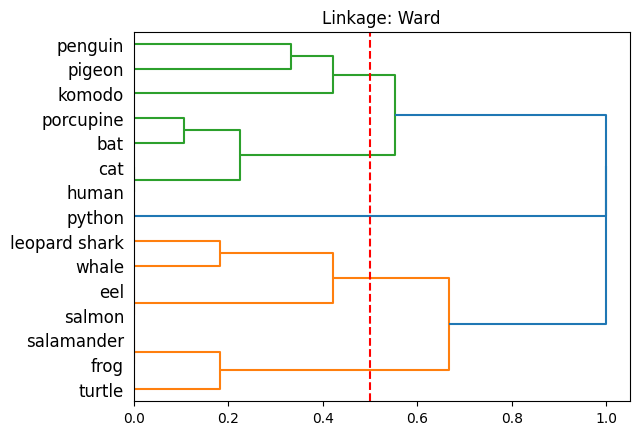

In [21]:
Z = linkage(X, method='complete', metric='cosine') # max
dn = dendrogram(Z, labels=names.tolist(),orientation='right')

plt.title("Linkage: Ward")
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

Hasta ahora hemos solo graficado los árboles, pero no hemos etiquetado los datos. Ahora podemos usar `scikit-learn` con `AgglomerativeClustering`. Aquí tenemos varias opciones.
* Si sabemos cuantos clusters queremos (viendo el dendrograma), agregamos el parametro `n_clusters` y lo dejamos en cuántos clusters queremos.
* Si sabemos a la distancia que queremos cortar (tambien viendo el dendrograma), entonces usamos el parametro `distance_threshold`.
* En el caso de que no usemos `linkage` podemos hacer correr el algoritmo y que genere todo el arbol (dejando `n_clusters=None` y `distance_threshold=0`), luego calcular la matriz de relaciones a mano, graficarla usando el dendrograma, decidir dónde cortar y volver a unos de los 2 puntos anteriores.

Primero, generando todo el árbol.

In [22]:
from sklearn.cluster import AgglomerativeClustering

complete_all = AgglomerativeClustering(linkage="complete", 
                                       affinity='cosine', 
                                       n_clusters=None, 
                                       distance_threshold=0).fit(X)

print(complete_all.n_clusters_)

15


Como generamos el árbol entero tenemos tantos clusters como datos! Ahora, viendo el dendrograma anterior de `complete` decidimos que queremos 3 clusters. Entonces usamos lo siguiente:

In [23]:
complete_3 = AgglomerativeClustering(linkage="complete",
                                     affinity='cosine', 
                                     n_clusters=3).fit(X)

print(complete_3.n_clusters_)
print(complete_3.labels_)

3
[1 2 0 0 0 1 1 1 1 0 0 1 1 0 0]


Por supuesto, también podríamos haber decidido una distancia de donde cortar en vez de un número de clusters. En ese caso hacemos lo siguiente:

In [24]:
complete_dist = AgglomerativeClustering(linkage="complete", 
                                       affinity='cosine', 
                                       n_clusters=None, 
                                       distance_threshold=0.8).fit(X)
print(complete_dist.n_clusters_)
print(complete_dist.labels_)

3
[1 2 0 0 0 1 1 1 1 0 0 1 1 0 0]


Finalmente igual que en el caso de K-Means, podemos graficar nuestros clusters pintando cada dato del color asignado a cada cluster.

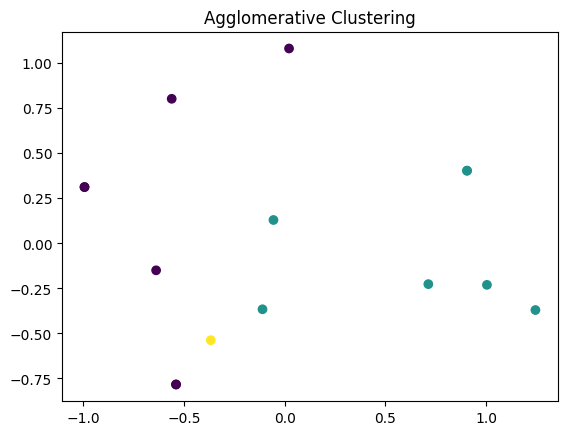

In [25]:
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X) 

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=complete_dist.labels_)
plt.title("Agglomerative Clustering")
plt.show()

## DBScan

Algoritmo de clustering basado en densidad. DBSCAN está implementado en `scikit-learn` y necesita de los parametros `eps` y `min_samples`. `eps` corresponde a la distancia dentro de la cual se consideran 2 puntos vecinos, `min_samples` es el número de vecinos que tiene que tener un punto para ser considerado un punto _core_.

Carguemos los siguientes datos en dos dimensiones y grafiquémoslos:

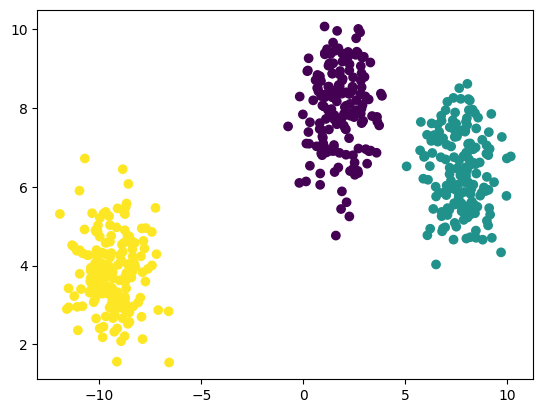

In [26]:
from sklearn import datasets

# Generamos 500 datos con 2 features aleatorias, centrado alrededor de 3 centroides
X, y = datasets.make_blobs(n_samples=500, n_features=2, 
                           centers=3, random_state=20)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Aplicaremos DBScan con valores eps=0.5 y minPts=5:

Esta implementación asocia los puntos de ruido al cluster ID con valor `-1`.

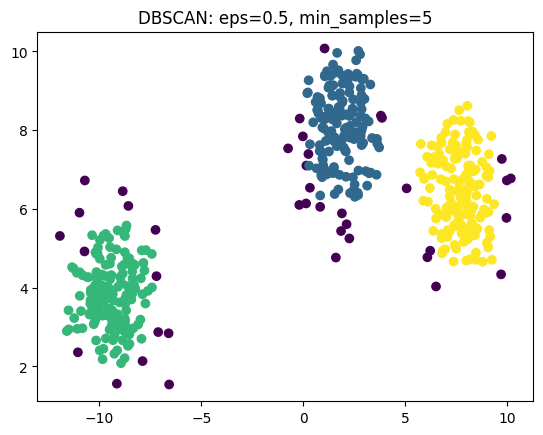

In [27]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

In [28]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2], dtype=int64)

`eps` es el parametro más importante de DBSCAN, por lo que tenemos que elegirlo con cuidado. En este caso podemos ver que dice que hay 4 "clusters", de los cuales 3 son clusters reales y el resto es considerado como ruido.

Ahora probemos con un dataset un poco distinto, unos círculos concéntricos.

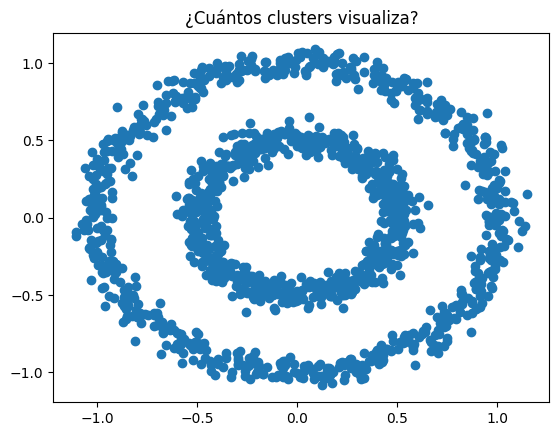

In [29]:
X2, y2 = datasets.make_circles(n_samples=1500, factor=.5,noise=.05)
plt.scatter(X2[:,0], X2[:,1])
plt.title("¿Cuántos clusters visualiza?");

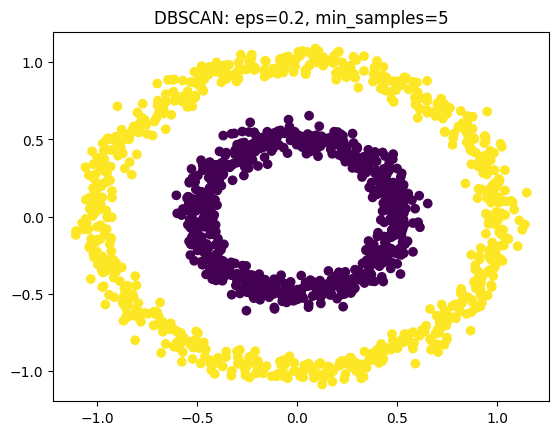

In [30]:
eps = 0.2
min_samples = 5

dbscan_circles = DBSCAN(eps=eps, min_samples=min_samples).fit(X2)
plt.scatter(X2[:,0], X2[:,1], c=dbscan_circles.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

**¿Con k-means?**



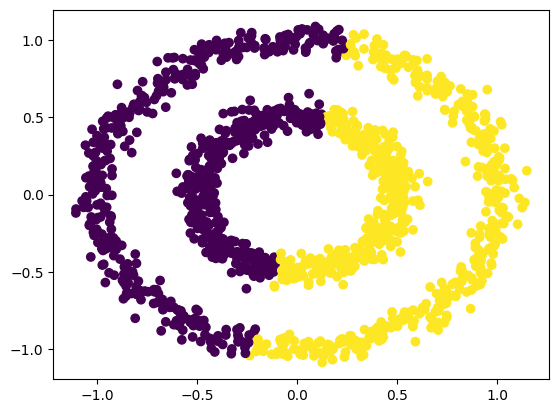

In [31]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(X2)
plt.scatter(X2[:,0], X2[:,1], c=kmeans.labels_)
plt.show()

**Estimación del `eps` usando el `método de la rodilla` (basado en KNN).**

____


Para esto, vamos a fijar un valor de `minPts`. 
Luego vamos a graficar la distancia de cada punto del dataset a su `minPts` vecino más cercano.
La idea es calcular la distancia promedio de cada punto a sus vecinos más cercanos los cuales son graficados en orden ascendente. El objetivo es determinar la `rodilla`, que corresponde al valor óptimo de `eps`.

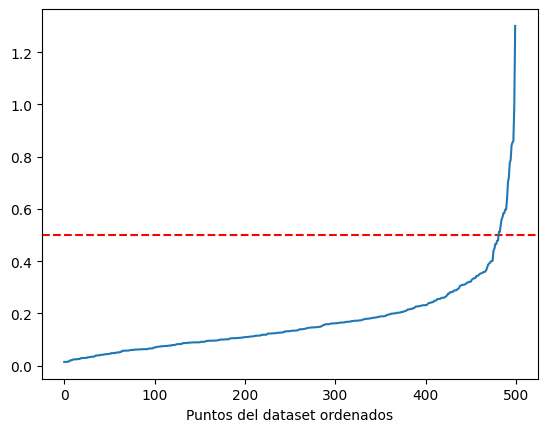

In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

N = 5
nbrs = NearestNeighbors(n_neighbors=N).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=0.5, color='r', linestyle='--') #Ajuste el valor para y
plt.xlabel('Puntos del dataset ordenados')
plt.plot(distances);

# Evaluación de clusters

Evaluar la calidad de nuestros clusters es algo no trivial. 
En 2 dimensiones podemos encontrar separaciones de clusters visualmente. El tema es que rara vez tendremos solo 2 dimensiones en nuestros datos. Para más dimensiones tenemos que depender de técnicas de reducción de dimensionalidad.

En esta sección veremos algunas forma de evaluar clusters, sea visual o numéricamente.

## Matriz de similitud (proximidad)

Estas matrices nos permiten ver qué tan cerca están los puntos pertenecientes a un cluster entre sí, y simultaneamente ver qué tan lejos están los puntos de un cluster de los otros clusters.

In [33]:
from sklearn.metrics.pairwise import euclidean_distances

def sim_matrix(features, labels):
    useful_labels = labels >= 0

    # primero ordenamos los datos en base al cluster que pertencen
    indices = np.argsort(labels[useful_labels])
    sorted_features = features[useful_labels][indices]

    # calculamos las distancias entre todos los puntos
    d = euclidean_distances(sorted_features, sorted_features)
    return d

def plot(data, model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

    fig.suptitle(f"{model.__class__.__name__}")

    ax1.scatter(data[:,0], data[:,1], c=model.labels_)

    dist = sim_matrix(data, model.labels_)
    im = ax2.imshow(dist, cmap="jet")
    fig.colorbar(im, ax=ax2)

Usemos el siguiente dataset que tiene 4 clusters con distintas densidades, donde uno de ellos es bastante _sparse_ comparado con el resto.

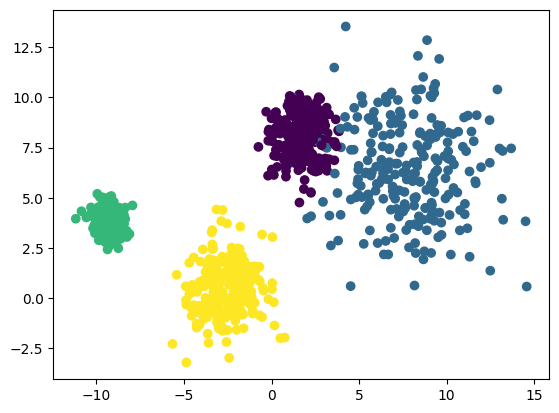

In [34]:
from sklearn import datasets

random_state = 20

X, y = datasets.make_blobs(n_samples=1000, centers=4, 
                             cluster_std=[1.0, 2.5, 0.5, 1.2], 
                             random_state=random_state)

plt.scatter(X[:,0], X[:,1], c=y);

Obtenemos los siguientes resultados.

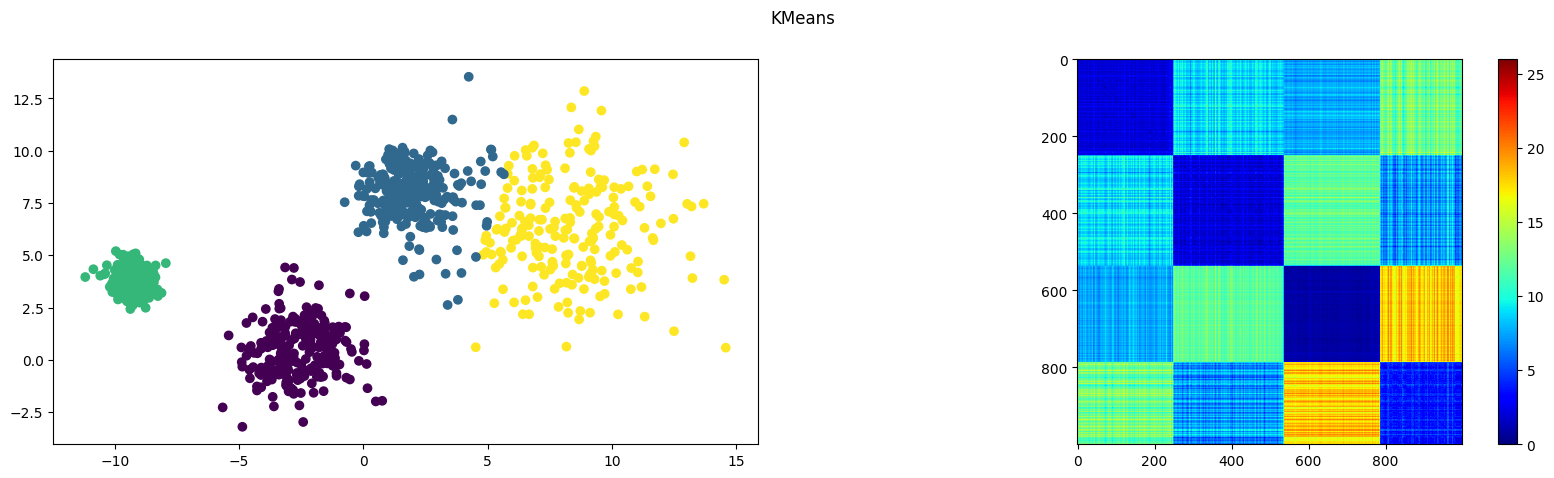

In [35]:
kmeans = KMeans(n_clusters=4, random_state=random_state).fit(X)

plot(X, kmeans)
plt.show()

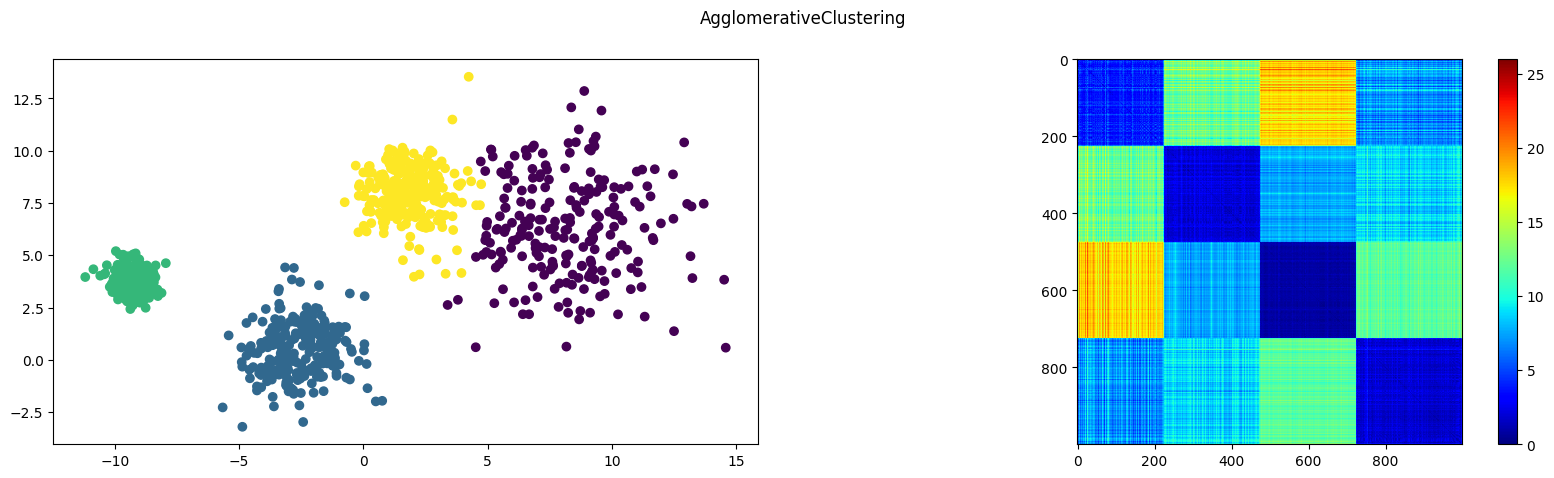

In [36]:
ward_link = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X)

plot(X, ward_link)
plt.show()

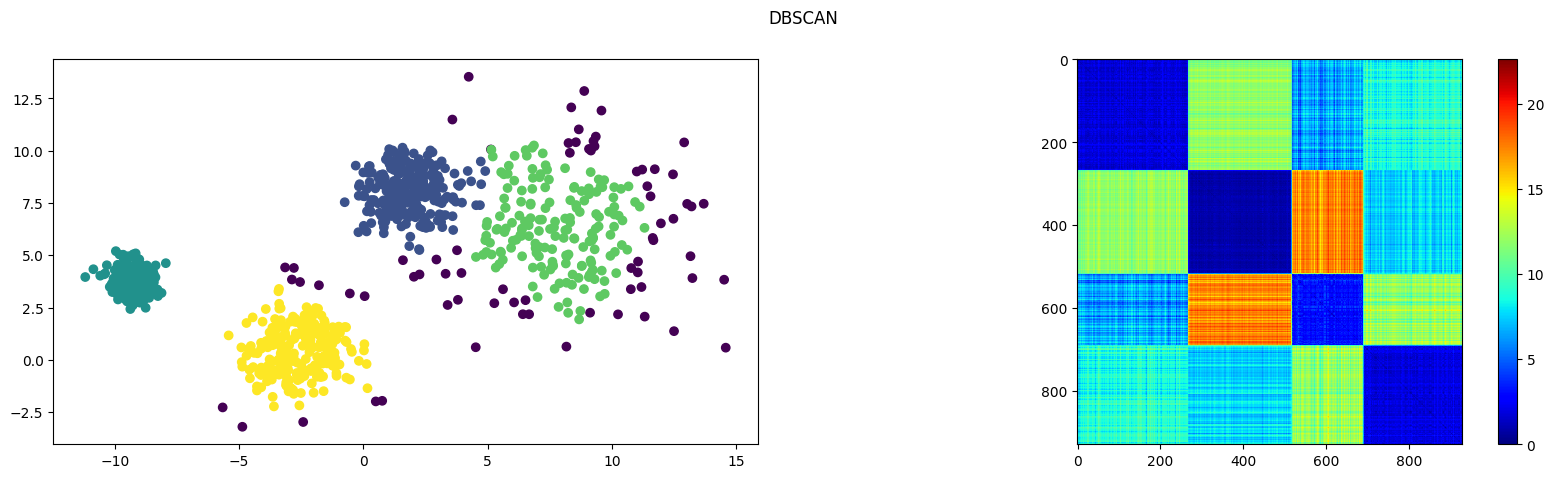

In [37]:
dbscan = DBSCAN(eps=0.98, min_samples=10).fit(X)

plot(X, dbscan)
plt.show()

Solo K-Means capturó correctamente los 4 clusters. Ambos, clustering aglomerativo y DBSCAN consideran el clustering de baja densidad como una extensión de otro.

## Silhouette

Presentaremos otra forma de evaluar clusters, esta vez de una manera no visual usando el coeficiente de Silhouette. Este coeficiente calcula para cada punto:

1) su distancia promedio al resto de los puntos en su misma clases, digamos `a`. En ingles esto se llama `mean intra-cluster distance`.

2) su distancia promedio a todos los puntos del cluster mas cercano, digamos `b`. En ingles esto se llama `mean nearest-cluster distance`.
Entonces el coeficiente de Silhouette se calcula con la siguiente formula:
$$\frac{b - a}{max(a, b)}$$

Esta métrica esta en un rango entre -1 y 1, donde:

* 1 significa que algo está bien asignado, 
* -1 significa que algo está mal asignado porque hay otro cluster más similar, y 
* 0 significa que hay solapamiento de clusters.

El coeficiente de Silhouette se calcula pasando el dataset y los labels asignados por el metodo de cluster:
```python
silhouette_score(<dataset>, <labels>)
```

In [38]:
from sklearn.metrics import silhouette_score

print("Dataset X K-Means\t", silhouette_score(X, kmeans.labels_))
print("Dataset X Ward Agg\t", silhouette_score(X, ward_link.labels_))
# para DBSCAN tenermos que filtrar las labels negativas, ya que representan ruido, no otro cluster:
_filter_label = dbscan.labels_ >= 0
print("Dataset X DBSCAN\t", silhouette_score(X[_filter_label], dbscan.labels_[_filter_label]))

Dataset X K-Means	 0.6816575119745327
Dataset X Ward Agg	 0.679160994209237
Dataset X DBSCAN	 0.717867827465966


## Información mutua

Si tenemos el label verdadero de cada cluster (casi nunca), podemos aplicar otras técnicas para evaluar los clusters que obtenemos. Una de esas otras técnicas es la Infomación Mutua, que básicamente ve la dependencia entre 2 distribuciones, nuestra distribucion real que conocemos (que casi nunca tenemos), y la que nos dio nuestro método de clustering. Para más detalles y la formulación mátematica vean el siguiente link: https://scikit-learn.org/stable/modules/clustering.html#id12

`sklearn` presenta 3 versiones de este concepto, Mutual Information (MI), Normalized Mutual Information (NMI), y Adjusted Mutual Information (AMI). La primera es un valor que mide la información mutua pero no está acotado entonces no sabemos que tan bueno o malo es teniendo solo el valor aislado. NMI y AMI están normalizados en el rango 0-1, así que es más fácil tener una idea de que significa el número. Los valores cercanos a 1 indican una buena agrupación.

In [39]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score

In [40]:
print("Dataset X K-Means\t", normalized_mutual_info_score(y, kmeans.labels_))


Dataset X K-Means	 0.9222620006750305


In [41]:
print("Dataset X Ward Agg\t", normalized_mutual_info_score(y, ward_link.labels_))


Dataset X Ward Agg	 0.9404185439808234


In [42]:
print("Dataset X DBSCAN\t", 
      normalized_mutual_info_score(y[_filter_label], dbscan.labels_[_filter_label]))

Dataset X DBSCAN	 0.9489773450883032


# Referencias

*   https://scikit-learn.org/stable/modules/clustering.html

* https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

*   http://www.cse.msu.edu/~ptan/dmbook/software/